In [21]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
from math import ceil

from IPython.display import Audio

In [22]:
# load a random audio file and display an audio player

d = "../datasets/birdsongs-combined/train_audio"
random_dir = f"{d}/{random.choice(os.listdir(d))}/"
random_file = random_dir + random.choice(os.listdir(random_dir))

random_file

'../datasets/birdsongs-combined/train_audio/integr/XC397702.ogg'

In [23]:
data, sample_rate_hz = librosa.load(random_file, sr=None)

In [24]:
data # sample values

array([ 2.7625972e-06, -7.2371204e-06,  5.1629331e-06, ...,
        5.9548388e-03, -6.5102102e-03, -1.4443481e-02], dtype=float32)

In [25]:
data.shape # total samples

(59350,)

In [26]:
sample_rate_hz # sample rate of file

32000

In [27]:
data.shape[0] / sample_rate_hz # duration of file

1.8546875

In [28]:
data_series = pd.Series(data) # for ease of use going forward
# convert index into seconds to make it easier
# divide by sample rate
data_series.index = data_series.index / sample_rate_hz
data_series

0.000000    0.000003
0.000031   -0.000007
0.000063    0.000005
0.000094   -0.000040
0.000125    0.000042
              ...   
1.854531    0.001507
1.854562    0.002045
1.854594    0.005955
1.854625   -0.006510
1.854656   -0.014443
Length: 59350, dtype: float32

In [29]:
def plot_audio(data_series: pd.Series, end: int = -1):
    plt.figure(figsize=(15,5))
    data_series.plot.line()
    plt.grid(axis="x") # no point showing y axis for grid lines
    #plt.xticks(np.linspace(0, ceil(max(data_series.index)), 10))
    plt.title(random_file)
    plt.xlabel("Time (secs)")
    plt.ylabel("Amplitude")
    plt.xlim((0, ceil(max(data_series.index)) if end == -1 else end)) # IN CASE DATA/INDEX IS TRIMMED. START AT 0 AND END ON WHOLE VALUE
    plt.show()

In [30]:
Audio(random_file)

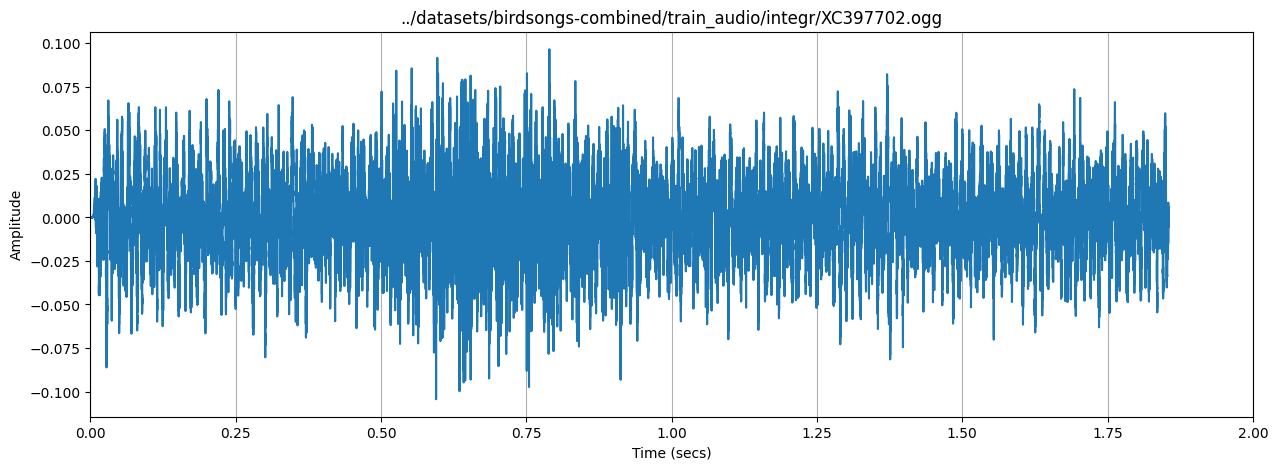

In [31]:
# original audio file

plot_audio(data_series)

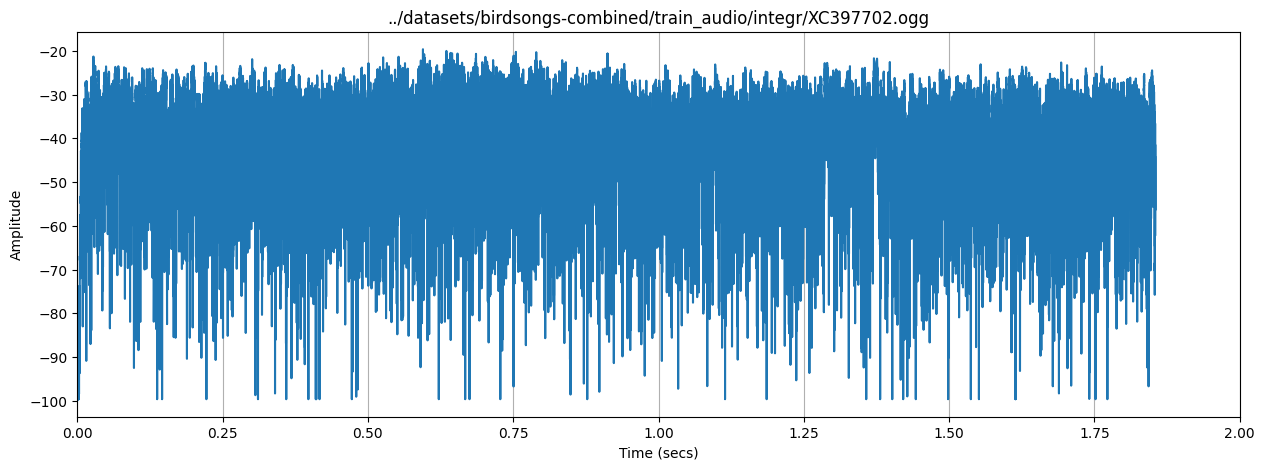

In [32]:
# convert amplitude to dB just to see what it looks like

data_db = librosa.amplitude_to_db(data)
data_db_series = pd.Series(data_db, index=data_series.index)

plot_audio(data_db_series)

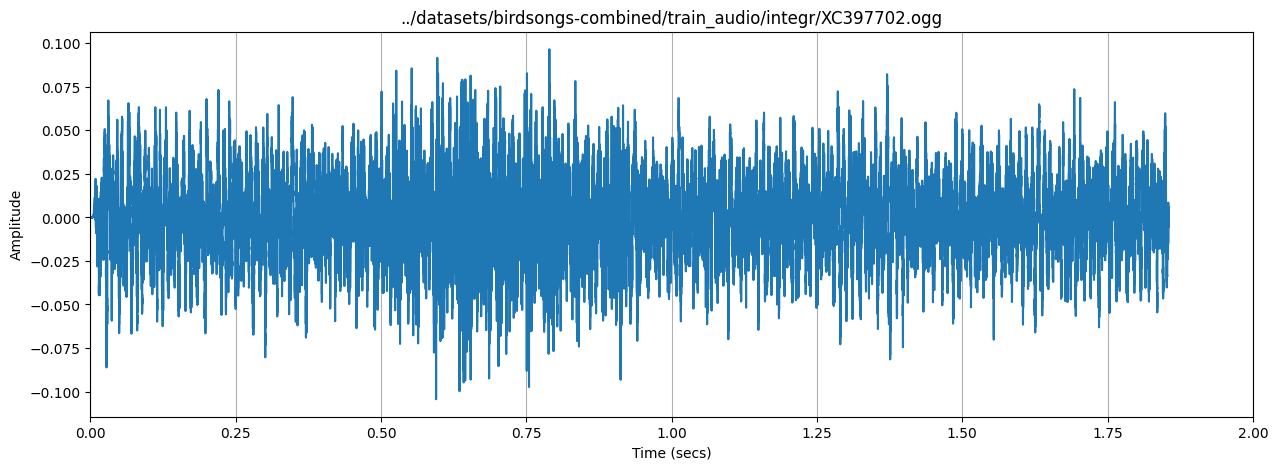

In [33]:
# trim to remove quiet/silent start/ends

data_trimmed, trim_index = librosa.effects.trim(data, top_db=20) # top_db = "silence" threshold. first value above this is when trimming STOPS. ref = root mean square of decibels if not defined
trim_index = trim_index / sample_rate_hz # scale index so that its in line with time sample
# first value = offset compared to original data. (set first index value in "data_trimmed" to this)
# second value = end of slice. should be maximum value of new offset data. if above ^ is done, 2nd value should be final value in index of data_trimmed

data_trimmed_series = pd.Series(data_trimmed)
data_trimmed_series.index = (data_trimmed_series.index / sample_rate_hz) + trim_index[0] # scale to match time, then offset trim value to ensure time is identical for each sample before the slice

plot_audio(data_trimmed_series, end = ceil(max(data_series.index)))

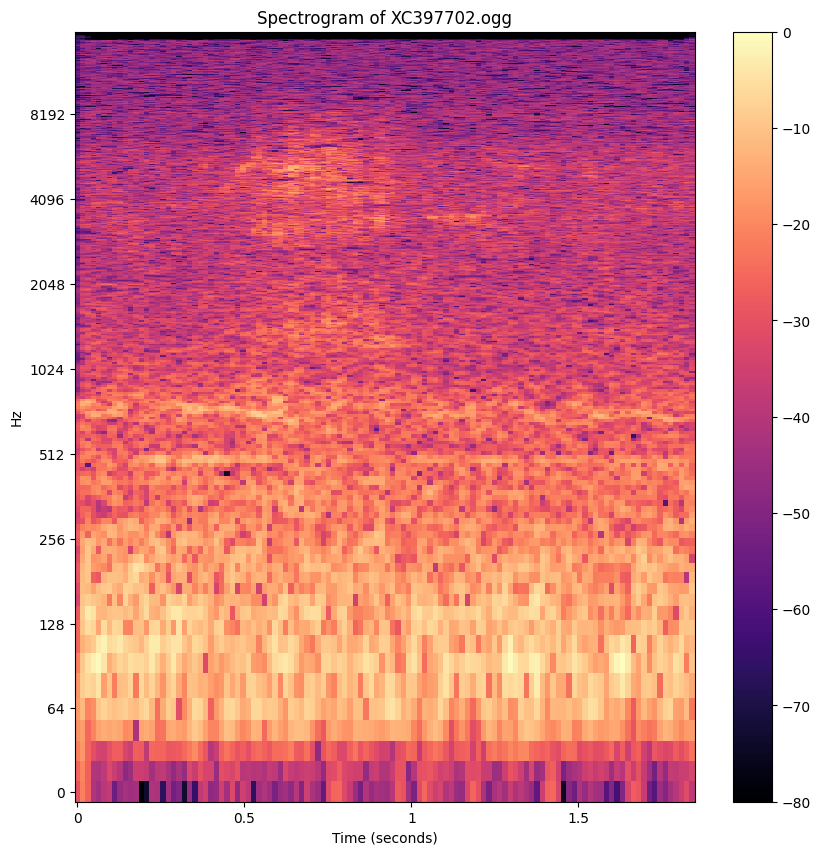

In [34]:
# spectrograms

data_transformed = librosa.stft(data) # applies short time fourier transform to data
# result is a list of complex values
# not interested in complex numbers, so take magnitude (NUMPY abs value) of numbers
# amplitude is not useful for visualisation, so convert amplitude to dB

# use dB for spectrograms as decibels are logarithmic.
# since various frequencies are logarithmic (to humans) it helps for visualisation/scaling purposes
# 1000-2000 hz means nothing on a scale from 1-21000 where frequencies get much higher pitch over time

spec_db = librosa.amplitude_to_db(np.abs(data_transformed), ref=np.max) # change/transform ref as you please

plt.figure(figsize=(10, 10))
librosa.display.specshow(spec_db, x_axis="s", y_axis="log", sr=sample_rate_hz) # x-axis and y-axis can change e.g. "log", "linear", "s" (for seconds). SPECIFY SAMPLE RATE HERE. OTHERWISE TIME X AXIS CAN BE DISTORTED
plt.colorbar()
plt.title(f"Spectrogram of {random_file.split("/")[-1]}")
plt.show()
# hover over function to display different types of display types

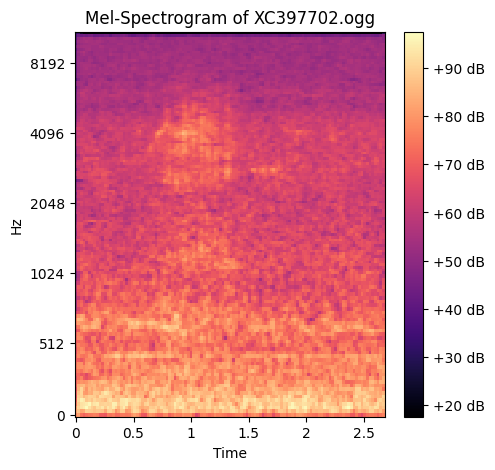

In [43]:
spg_mag, _ = librosa.magphase(data_transformed)
mel_scale_sgram = librosa.feature.melspectrogram(S=spg_mag, sr=sample_rate_hz)
mel_scale_sgram_db = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)

plt.figure(figsize=(5, 5))
librosa.display.specshow(mel_scale_sgram_db, x_axis="time", y_axis="mel")
plt.title(f"Mel-Spectrogram of {random_file.split("/")[-1]}")
plt.colorbar(format='%+2.0f dB')
plt.show()

In [38]:
mel_scale_sgram_db

array([[78.062614, 81.92346 , 74.106735, ..., 71.91784 , 74.84242 ,
        76.87124 ],
       [82.255295, 87.42974 , 82.36978 , ..., 84.07599 , 86.69406 ,
        81.40272 ],
       [80.47543 , 90.60305 , 93.118324, ..., 91.69838 , 85.742874,
        87.66506 ],
       ...,
       [40.26236 , 49.452557, 52.848686, ..., 51.35178 , 51.786987,
        49.42148 ],
       [37.83763 , 43.754486, 43.26194 , ..., 42.895737, 45.578075,
        48.505142],
       [30.792854, 33.072365, 22.75563 , ..., 17.558853, 17.558853,
        28.903778]], dtype=float32)